In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy import conj,argmax
from scipy import signal

In [2]:
# Set the log file path
logFileName = 'delay'
logFileType = '.BBL'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

In [3]:
# Create decode command
decodeCommand = decodePath + ' ' + logFilePath

# Decode
os.system(decodeCommand)

# blackbox_decode will create a .event file, we don't need that
junkFile = logFileName+'.01.event'
os.remove(junkFile)

In [4]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) # read data file into a pandas dataframe
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
time=time-time[0]
samplingRate = 1000000/np.median(np.diff(time)) #1000000 because the data is in us
print(samplingRate)

2000.0


In [5]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]

In [6]:
def calc_delay(a,b):
    a_fft   = fft(np.hamming(len(a)) *a)   #a must be later than b
    b_fft   = fft(np.hamming(len(b)) *b)   #hamming for now, maybe hanning is better?
    c       = ifft(a_fft*conj(b_fft))
    time_shift  = argmax(abs(c))
    return time_shift

def inter(x):
    tmp_a = np.arange(0,len(x),1)
    tmp_b = interpolate.interp1d(tmp_a,x)
    y = tmp_b(np.arange(0,len(x)-10,0.1))
    return y

In [7]:
def get_delay(axis, mode, skip_rate):
    if axis == 'roll':
        ax = 0
    if axis == 'pitch':
        ax = 1
    if axis == 'yaw':
        ax = 2

    if mode == 'filter':
        ip = gyroScaleData[ax]
        op = gyroADCData[ax]
    if mode == 'io':
        ip = setpointData[ax]
        op = gyroADCData[ax]
    
    ov_delay = calc_delay(op,ip)
    thr = thrData #range from 1000~2000
    buffer_size = 256
    thr_delay = np.zeros(100, dtype=np.float64)
    thr_count = np.zeros(100, dtype=np.int32)
    for i in range(0, len(ip)-buffer_size, int(skip_rate*buffer_size)):
        idx = i
        avgThr = int(np.sum(thr[idx:idx+buffer_size])/buffer_size/10) - 100
        if avgThr < 0:
            avgThr = 0
        if avgThr > 99:
            avgThr = 99
        inter_ip = inter(ip[idx:idx+buffer_size]) # Up sampling to increase precision
        inter_op = inter(op[idx:idx+buffer_size])
        tmp_delay = calc_delay(inter_op,inter_ip)
        if tmp_delay > 20*ov_delay:
            continue
        delay = tmp_delay/(int(samplingRate/100)) #not 1000 because of the 10 times up sampling
        thr_delay[avgThr] = thr_delay[avgThr]+delay
        thr_count[avgThr] += 1
    
    for i in range(100):
        if thr_count[i] != 0:
            thr_delay[i]=thr_delay[i]/thr_count[i]
    
    return thr_delay

In [12]:
filter_delay = get_delay('pitch','filter', 0.1)

In [13]:
io_delay = get_delay('pitch','io',0.1)

In [14]:
x = (thrData/10)-100

b, a = signal.butter(1,0.2)
mask_filt_delay = np.zeros(100, dtype=np.float64)
mask_io_delay = np.zeros(100, dtype=np.float64)
mask_filt_delay = signal.filtfilt(b, a, filter_delay)
mask_io_delay = signal.filtfilt(b, a, io_delay)
num_bins = 100 # 0-100
general_filt_delay = np.sum(mask_filt_delay[20:45]) / 25
general_io_delay = np.sum(mask_io_delay[20:45]) / 25 
# only take data where throttle lies in range 20-40%, which is the most often used range

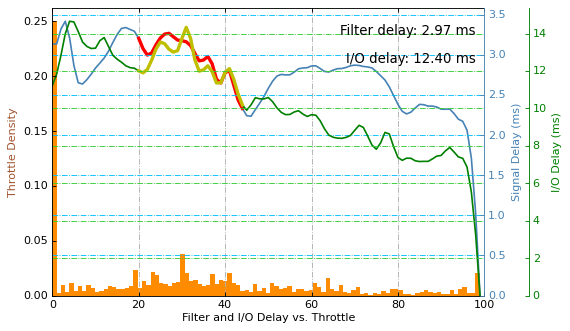

In [17]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes


fig = plt.figure(figsize=(6, 4), dpi= 80)
ax_thr = HostAxes(fig, [0, 0, 0.9, 0.9])  #

#parasite addtional axes, share x
ax_filt = ParasiteAxes(ax_thr, sharex=ax_thr)
ax_io = ParasiteAxes(ax_thr, sharex=ax_thr)

#append axes
ax_thr.parasites.append(ax_filt)
ax_thr.parasites.append(ax_io)

#invisible right axis of ax_thr
ax_thr.axis['right'].set_visible(False)
ax_thr.axis['top'].set_visible(True)
ax_filt.axis['right'].set_visible(True)
ax_filt.axis['right'].major_ticklabels.set_visible(True)
ax_filt.axis['right'].label.set_visible(True)

#set label for axis
ax_thr.set_ylabel('Throttle Density', color="sienna")
ax_thr.set_xlabel('Filter and I/O Delay vs. Throttle')
ax_filt.set_ylabel('Filter delay(ms)')
ax_io.set_ylabel('I/O delay(ms)')

load_axisline = ax_io.get_grid_helper().new_fixed_axis
ax_io.axis['right2'] = load_axisline(loc='right', axes=ax_io, offset=(40,0))
fig.add_axes(ax_thr)

#set limit of x, y
ax_thr.set_xlim(0,100)
n, bins, patches = ax_thr.hist(x, num_bins, density=True, color="darkorange")
ax_thr.grid(True,linestyle='-.',axis = 'x')


ax_filt.set_ylabel('Signal Delay (ms)', color='steelblue')
ax_filt.set_ylim(0,max(mask_filt_delay)*1.05)
ax_filt.plot(np.arange(20,45,1),mask_filt_delay[20:45],color='red',linewidth=3)
ax_filt.plot(mask_filt_delay, color='steelblue')
ax_filt.grid(True,linestyle='-.',axis = 'y', color = 'deepskyblue')
ax_filt.text(98, max(mask_filt_delay)*0.95, "Filter delay: %.2f ms"  %general_filt_delay, size= 'large', ha='right')


ax_io.set_ylabel('I/O Delay (ms)', color='g')
ax_io.set_ylim(0,max(mask_io_delay)*1.05)
ax_io.plot(np.arange(20,45,1),mask_io_delay[20:45],color='y',linewidth=3)
ax_io.plot(mask_io_delay, color='g')
ax_io.grid(True,linestyle='-.',axis = 'y',color = 'limegreen')
ax_io.text(98, max(mask_io_delay)*0.85, "I/O delay: %.2f ms"  %general_io_delay, size= 'large', ha='right')

#ax_thr.legend()

ax_filt.axis['right'].label.set_color('steelblue')
ax_io.axis['right2'].label.set_color('green')

ax_filt.axis['right'].major_ticks.set_color('steelblue')
ax_io.axis['right2'].major_ticks.set_color('green')

ax_filt.axis['right'].major_ticklabels.set_color('steelblue')
ax_io.axis['right2'].major_ticklabels.set_color('green')

ax_filt.axis['right'].line.set_color('steelblue')
ax_io.axis['right2'].line.set_color('green')

plt.show()